# An example for GPinv.linear_model

This notebook briefly shows an inference example for non-linear model

*Keisuke Fujii 5th Sept. 2016*

## Synthetic observation

Consider we observe a cylindrical transparent mediam with multiple ($N$) lines-of-sight, as shown below.

<img src=figs/abel_inversion.png width=240pt>

The local emission intensity $f$ is a function of the radius $r$.
The observed emission intensity $\mathbf{Y}$ is a result of the integration along the line-of-sight as
$$
\mathbf{Y} = \int_{x} g(r) dx + \mathbf{e}
$$

where $\mathbf{e}$ is a i.i.d. Gaussian noise.

We divided $g$ into $n$ discrete points $\mathbf{f}$, then the above integration can be approximated as follows
$$
\mathbf{Y} = \mathrm{A} \mathbf{g} + \mathbf{e}
$$

## Non-linear model and transform

We assume 
$$
g(r) = \exp(f(r))
$$
where $f(r)$ follows the Gaussian Process with kernel $\mathrm{K}$.
This transformation makes the latent function is always positive.

This inverse problem is non-linear.

In this notebook, 
we make inference for $\mathbf{g}$ by 
1. Vanilla MCMC
2. Variational Gaussian process regression.
3. Sparse variational Gaussian process regression.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
# In ../testing/ dir, we prepared a small script for generating the above matrix A
sys.path.append('../testing/')
from test_linear_model import make_LosMatrix
# Import GPinv
import GPinv

## Synthetic signals

Here, we make a synthetic measurement.
The synthetic signal $\mathrm{y}$ is simulated from the grand truth solution $g_true$ and random gaussian noise.

In [2]:
n = 30
N = 40
# radial coordinate
r = np.linspace(0, 1., n)
# synthetic latent function
f = np.exp(-(r-0.3)*(r-0.3)/0.1) + np.exp(-(r+0.3)*(r+0.3)/0.1)

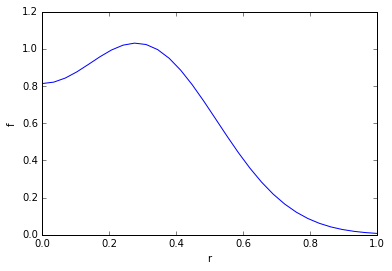

In [3]:
# plotting the latent function
plt.plot(r, f)
plt.xlabel('r')
plt.ylabel('f')

### Prepare the synthetic signal.

In [4]:
# los height
z = np.linspace(-0.9,0.9, N)
# Los-matrix
A = make_LosMatrix(r, z)

In [5]:
# noise amplitude 
e_amp = 0.1
# synthetic observation
y = np.dot(A, f) + e_amp * np.random.randn(N)

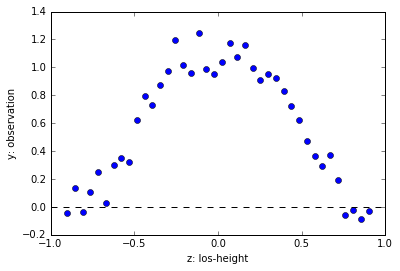

In [6]:
plt.plot(z, y, 'o', [-1,1],[0,0], '--k')
plt.xlabel('z: los-height')
plt.ylabel('y: observation')

# Inference

In order to carry out an inference, a custom **likelihood**, which calculates $p(\mathbf{Y}|\mathbf{g})$ with given $\mathbf{g}$, must be prepared according to the problem.

In entire **GPinv**, we assume that the observed signal $\mathbf{y}$ is independent with conditioned by the latent function $\mathbf{f}$, i.e.,
$$
p(\mathbf{Y}|\mathbf{g}) = \prod_{i} p(y_i|\mathbf{g}).
$$



In particular, we require two methods in **likelihood** class, 
i.e.
**transform** and **logp** methods.

In **transform** method, a transform from a GP function $\mathbf{f}$ to the latent value at the observation point should be described.

In **logp** method, the conditional probability for each data point should be described.

In [7]:
class AbelLikelihood(GPinv.likelihoods.TransformedLikelihood):
    def __init__(self, Amat, num_samples=20):
        GPinv.likelihoods.TransformedLikelihood.__init__(self, num_samples)
        # store A matrix as data
        self.Amat = GPinv.param.DataHolder(Amat)
        # gaussian noise is assumed. The variance parameter will be inferred.
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)

    def transform(self, F):
        """
        In this method, the latent function f is transformed to the latent values 
        for observation y_i.
        
        F is a tf.tensor with shape [P, N', M'], 
        where N is number of expressive coordinate (in this example, r.shape[0])
        M is a dimension for the latent function (in this example, 1),
        P is 1 for MCMC while self.num_samples for VGP.
        
        Note that since the merginal for the latent values is approximated by a Gaussian,
        the result should be projected into the real space.
        In this example, the latent value is always positive, so we project into real space
        by log function.
        """
        Amat = tf.tile(tf.expand_dims(self.Amat, [0]), [tf.shape(F)[0], 1,1])
        return tf.log(tf.batch_matmul(Amat, tf.exp(F)))

    def logp(self, X, Y):
        """
        X is the latent value with respect to the observation Y.
        X, Y shape is [P, N, M]
        """
        return GPinv.densities.gaussian(tf.exp(X), Y, self.variance)

### Likelihood for the sparse model

For the sparse model, data should be stored as Minibatch data

In [8]:
class AbelMinibatchLikelihood(AbelLikelihood):
    def __init__(self, Amat, minibatch_size, num_samples=20):
        GPinv.likelihoods.TransformedLikelihood.__init__(self, num_samples)
        # store A matrix as data
        self.Amat = GPinv.param.MinibatchData(Amat, minibatch_size)
        # gaussian noise is assumed. The variance parameter will be inferred.
        self.variance = GPinv.param.Param(np.ones(1), GPinv.transforms.positive)        

## Kernel

The statistical property is interpreted in Gaussian Process kernel.

In our example, since $f$ is a cylindrically symmetric function, we adopt **RBF_csym** kernel.

For MCMC, small additional jitter is necessary for the kernel to keep the numerical stability. 
Here, we choose 1e-4

In [9]:
kern = GPinv.kernels.RBF_csym(1) + GPinv.kernels.White(1)
# jitter variance
kern.white.variance = 1.0e-4

### Inference by vanilla MCMC (GPMC)

In [10]:
# Instantiate model, with kernel coordinate r, observation y, kernel, likelihood and mean.
model_mc = GPinv.nonlinear_model.GPMC(r.reshape(-1,1), y.reshape(-1,1), 
                                   kern = kern, 
                                   mean_function = GPinv.mean_functions.Constant(np.ones(1)),
                                   likelihood=AbelLikelihood(A))

In [11]:
# Initialization of parameter sometimes necessary.
model_mc.likelihood.variance=0.1

In [12]:
# make sampling 
samples = model_mc.sample(500, burn=400, verbose=True)

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  98.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  93.0 %


### Variational inference by VGP

In [13]:
model_vgp = GPinv.nonlinear_model.VGP(r.reshape(-1,1), y.reshape(-1,1), 
                           kern = GPinv.kernels.RBF_csym(1),
                           mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                           likelihood=AbelLikelihood(A, 40))

In [14]:
_= model_vgp.optimize(tf.train.AdamOptimizer(learning_rate=0.05), maxiter=3000)

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


## Sparse variational inference by SVGP

In [15]:
minibatch_size = 10

model_svgp = GPinv.nonlinear_model.SVGP(r.reshape(-1,1), y.reshape(-1,1), 
                            kern = GPinv.kernels.RBF_csym(1),
                            mean_function = GPinv.mean_functions.Constant(-2.*np.ones(1)),
                            likelihood=AbelMinibatchLikelihood(A, minibatch_size, 40),
                            Z = np.linspace(0,1,5).reshape(-1,1),
                            minibatch_size=minibatch_size)

In [16]:
_= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.05), maxiter=3000)

/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1750: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


InvalidArgumentError: Incompatible shapes: [1,30,30] vs. [1,5,5]
	 [[Node: gradients_4/model.build_likelihood_2/add_1_grad/BroadcastGradientArgs = BroadcastGradientArgs[_device="/job:localhost/replica:0/task:0/cpu:0"](gradients_4/model.build_likelihood_2/add_1_grad/Shape, gradients_4/model.build_likelihood_2/add_1_grad/Shape_1)]]
Caused by op 'gradients_4/model.build_likelihood_2/add_1_grad/BroadcastGradientArgs', defined at:
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-a84a704b562c>", line 1, in <module>
    _= model_svgp.optimize(tf.train.AdamOptimizer(learning_rate=0.05), maxiter=3000)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 218, in optimize
    return self._optimize_tf(method, callback, maxiter, **kw)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 224, in _optimize_tf
    opt_step = self._compile(optimizer=method)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 142, in _compile
    var_list=[self._free_vars])
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 196, in minimize
    grad_loss=grad_loss)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 253, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py", line 476, in gradients
    in_grads = _AsList(grad_fn(op, *out_grads))
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py", line 499, in _AddGrad
    rx, ry = gen_array_ops._broadcast_gradient_args(sx, sy)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 366, in _broadcast_gradient_args
    name=name)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'model.build_likelihood_2/add_1', defined at:
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 20 identical lines from previous traceback]
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 224, in _optimize_tf
    opt_step = self._compile(optimizer=method)
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/model.py", line 130, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/home/keisukefujii/Dropbox/projects/GPflow.git/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/home/keisukefujii/Dropbox/projects/GPinv/GPinv/svgp.py", line 81, in build_likelihood
    tf.batch_cholesky(tf.transpose(fcov, [2,0,1]) + jitter), [1,2,0])
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 760, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 71, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/keisukefujii/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


# Result

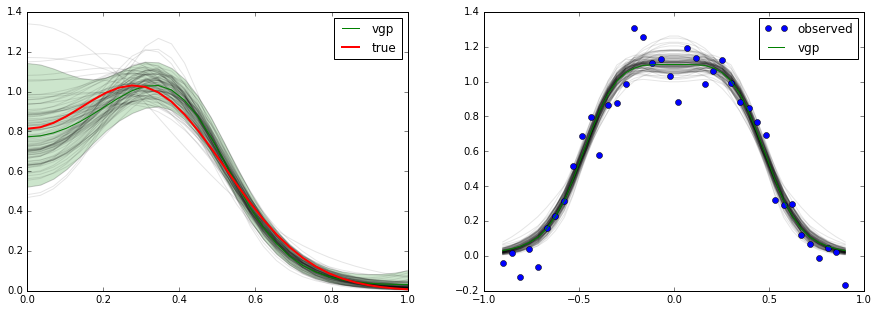

In [23]:
r_new = np.linspace(0.,1., 30)

plt.figure(figsize=(15,5))
for s in samples[::5]:
    model_mc.set_state(s)
    f_pred = model_mc.predict_f(r_new.reshape(-1,1))
    plt.subplot(1,2,1)
    plt.plot(r_new, np.exp(f_pred[0]),'k', alpha=0.1)
    plt.subplot(1,2,2)
    plt.plot(z, np.dot(A, np.exp(f_pred[0])),'k', alpha=0.1)

plt.subplot(1,2,1)
f_pred, f_var = model_vgp.predict_f(r_new.reshape(-1,1))
f_plus = np.exp(f_pred.flatten() + 2.*np.sqrt(f_var.flatten()))
f_minus = np.exp(f_pred.flatten() - 2.*np.sqrt(f_var.flatten()))
plt.fill_between(r_new, f_plus, f_minus, facecolor='g', alpha=0.2)
plt.plot(r_new, np.exp(f_pred.flatten()), 'g', label='vgp')
plt.plot(r, f, '-r', label='true',lw=2)
plt.plot([0,1],[0,0],'--k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(z, y, 'bo',lw=2, label='observed')
plt.plot(z, np.dot(A, np.exp(f_pred.flatten())), 'g', label='vgp')
plt.legend()